In [3]:
import pandas as pd
import re
import nltk
import glob
from gensim import corpora
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.ldamodel import LdaModel
pd.set_option('display.max_rows', None)

## Read in Company Values Data

### Text Preprocessing Functions:

In [4]:
# Regex and tokenizing text:
# takes text, removes special characters and punctuation 
# and returns a list of lower-cased tokenized words
def tokenize_sentences(text):
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)" 
    raw_tokens = nltk.regexp_tokenize(text, pattern)
    return [token.lower() for token in raw_tokens]

# Removing stopwords:
# removes stopwords from pre-tokenized list of words
def remove_stopwords(token_list, custom_words= []):
    return [word for word in token_list if word not in stopwords.words('english')+custom_words]

Read in text files

In [5]:
# read in all .txt files in our company_pages folder
path = '../data/company_pages'
files = [f for f in glob.glob(path + "**/*.txt", recursive=True)]

In [6]:
# Create a dataframe

# list of text
li = [open(f).read() for f in files]
# list of company names using the text file name
companies = [f.split('/')[-1][:-4] for f in files]

all_values = pd.DataFrame({'company':companies, 'company_values':li})
all_values.head()

,company,company_values
0,metlife,Caring for and respecting customers is core to...
1,dell,Customers: We believe our customer relationshi...
2,johnsonjohnson,We believe our first responsibility is to the ...
3,lowes,Lowe’s Vision: We will provide customer-valued...
4,fedex,FedEx Corporation will produce superior financ...


### Clean the values data by removing special characters, line endings, and converting to lower case

In [7]:
# Getting rid of spaces and line endings, convering to lower case
all_values.company_values = all_values.company_values.map(lambda x: re.sub('\s+', ' ', x.lower()))
# Getting rid of special characters
all_values.company_values = all_values.company_values.map(lambda x: re.sub('[^a-zA-Z0-9 \n\.]', '', x))

all_values.company_values[0]

'caring for and respecting customers is core to everything we do. it defines our work and shapes the culture for our people radiating out to our shareholders and communities. the financial security that metlife offers enables people to achieve more of what they want. our work makes a real difference in peoples lives  and uniting behind our values allows us to better fulfill our promises and helps us navigate life together. our values provide employees and distribution partners with a shared foundation for daytoday decision making and guide us as one metlife. put customers first caring for and respecting customers is core to everything we do. our customer focus defines our work shapes our culture and radiates out to our shareholders and communities. be the best we are relentless in our search for new and better ways of doing things. as a leader in our industry we constantly raise the bar take calculated risks and learn quickly from our mistakes. make things easier products in our indust

## LDA Topic Modeling:

In [11]:
from gensim.corpora.dictionary import Dictionary
from nltk.corpus import stopwords

In [12]:
# list of company_values
values_list = all_values.company_values.values.tolist()
# list of tokens list
values_tokens = [tokenize_sentences(value) for value in values_list]
# remove stopwords from each tokens list
values_tokens = [remove_stopwords(value, custom_words = all_values.company.values.tolist()+['fannie', 'work', 'business', 'company', 'customers', 'home', 'depot', 'ge', 'employees', 'people']) for value in values_tokens]  

In [178]:
common_dictionary = Dictionary(values_tokens)
common_corpus = [common_dictionary.doc2bow(text) for text in values_tokens]
lda_values = LdaModel(common_corpus, id2word = common_dictionary, num_topics=7, passes=10, random_state=25)

In [179]:
doc_topics = list(lda_values.get_document_topics(common_corpus))

# Examine topic clusters

lda_values.show_topics(num_topics = 7, num_words = 10) # remove index to show all topics

[(0,
  '0.006*"believe" + 0.006*"technology" + 0.004*"every" + 0.004*"value" + 0.004*"diversity" + 0.004*"innovation" + 0.004*"diverse" + 0.004*"respect" + 0.004*"integrity" + 0.004*"others"'),
 (1,
  '0.011*"us" + 0.009*"communities" + 0.007*"every" + 0.007*"world" + 0.007*"trust" + 0.007*"make" + 0.006*"relationships" + 0.006*"associates" + 0.006*"experiences" + 0.006*"improve"'),
 (2,
  '0.017*"leaders" + 0.008*"value" + 0.006*"best" + 0.006*"teams" + 0.005*"trust" + 0.005*"others" + 0.005*"improve" + 0.005*"develop" + 0.004*"new" + 0.004*"diverse"'),
 (3,
  '0.010*"communities" + 0.008*"success" + 0.008*"health" + 0.008*"best" + 0.007*"better" + 0.006*"diversity" + 0.006*"excellence" + 0.006*"values" + 0.005*"integrity" + 0.005*"us"'),
 (4,
  '0.018*"must" + 0.008*"help" + 0.007*"communities" + 0.007*"believe" + 0.006*"health" + 0.006*"make" + 0.006*"environment" + 0.006*"new" + 0.006*"diversity" + 0.005*"relationships"'),
 (5,
  '0.006*"right" + 0.006*"value" + 0.006*"communities"

## NMF Modeling:

In [76]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize

# converting back to list of company_values text without stopwords

sentences = []
for value in values_tokens:
    sentences.append(' '.join(token for token in value))

vectorizer = CountVectorizer(analyzer = "word", max_features = 10_000)

word_counts = vectorizer.fit_transform(sentences)

tfidf_transform = TfidfTransformer(smooth_idf = False)

words_tfidf = tfidf_transform.fit_transform(word_counts)

# final_words = normalize(words_tfidf, norm = 'l1')

In [79]:
model = NMF(n_components = 10, init = 'nndsvd')

W = model.fit_transform(words_tfidf)

W.shape

H = model.components_

H.shape

lst = []

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        lst.append(message)
    return lst

topics_nmf = (print_top_words(model, vectorizer.get_feature_names(), 10))



nmfsplit = [item.split() for item in topics_nmf]

pd.DataFrame(nmfsplit)

,0,1,2,3,4,5,6,7,8,9,10,11
0,Topic,#0:,bring,communities,right,culture,looking,cardinal,genuine,competitive,create,drive
1,Topic,#1:,employees,conduct,code,compliance,ethics,culture,concerns,policies,mae,maes
2,Topic,#2:,safety,highest,team,diversity,honor,protect,values,members,communities,people
3,Topic,#3:,associates,healthcare,vendors,consumers,expect,improving,anthems,involvement,thing,value
4,Topic,#4:,must,health,care,better,help,people,make,behave,path,enterprise
5,Topic,#5:,technology,believe,everyone,environmental,computing,ai,products,trustworthy,innovation,force
6,Topic,#6:,leaders,youre,teams,team,career,fun,clients,make,learning,ideas
7,Topic,#7:,financial,leader,talent,industry,employees,state,farm,promises,freddie,best
8,Topic,#8:,users,crises,nutrition,worlds,advancing,smart,chain,supply,sustainability,earths
9,Topic,#9:,world,dedication,passion,relationships,inspire,people,success,innovation,driven,around


## Clustering using TF-IDF Vectors:

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [81]:
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
#     stop_words = (['work', 'company', 'great','good', 'benefits'] + list(stopwords.words('english')))
    stop_words = (['fannie', 'work', 'business', 'company', 'customers', 'home', 'depot', 'ge'] + list(stopwords.words('english')))
#     stop_words = 'english'
)
tfidf.fit(sentences)
text = tfidf.transform(sentences)

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters
Fit 24 clusters
Fit 26 clusters
Fit 28 clusters
Fit 30 clusters
Fit 32 clusters
Fit 34 clusters
Fit 36 clusters
Fit 38 clusters
Fit 40 clusters
Fit 42 clusters
Fit 44 clusters
Fit 46 clusters
Fit 48 clusters
Fit 50 clusters


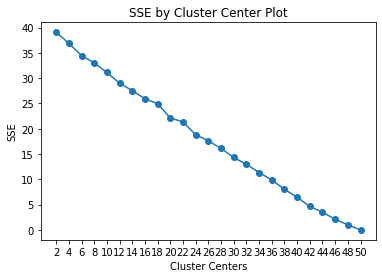

In [85]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(text, 50)

In [98]:
clusters = MiniBatchKMeans(n_clusters=7, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)

In [99]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
        

In [100]:
get_top_keywords(text, clusters, tfidf.get_feature_names(), 10)


Cluster 0
integrity,reach,giving,entrepreneurial,within,supporting,respect,culture,communities,right

Cluster 1
culture,members,every,commitment,environment,compliance,safety,code,conduct,employees

Cluster 2
one,communities,put,people,human,purpose,create,care,better,health

Cluster 3
inclusion,members,diversity,committed,promote,value,service,honesty,team,safety

Cluster 4
world,products,leaders,people,every,make,technology,believe,everyone,must

Cluster 5
relationships,employees,build,trust,communities,us,world,financial,success,people

Cluster 6
valued,place,culture,thing,improving,giving,us,corporate,care,associates


In [94]:
np.unique(clusters, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=int32),
 array([ 1,  9,  3,  5, 12, 17,  3]))

## Comparison with Reviews

-Use previous reviews LDA -> compare company X category concentrations to company X values concentrations

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Sample with just one company: Walgreens

We want to compare Walgreens reviews with all company values, then with just Walgreens' values. First, prep our Values data.

In [24]:
# Walgreens is index 44
all_values.loc[all_values.company == 'walgreens']

,company,company_values
44,walgreens,be the first choice for pharmacy wellbeing and...


In [25]:
values_text = []
for value in values_tokens:
    values_text.append(' '.join(token for token in value))
    
# take out stop words
tfidf = TfidfVectorizer(stop_words= list(stopwords.words('english'))+ ['fannie', 'work', 'business', 'company', 'customers', 'home', 'depot', 'ge'])
# fit transform the sentences
tfidf_values = tfidf.fit_transform(values_text)

In [26]:
# take average of values tfidf vector
avg_values_tfidf = np.average(tfidf_values.toarray(), axis=0)

In [27]:
# import reviews data
all_reviews = pd.read_csv('../data/all_reviews.csv')
walgreens = all_reviews.loc[all_reviews.company == 'Walgreens']

In [28]:
# now let's test out our TfidfVectorizer
pros_reviews_tfidf = tfidf.transform(walgreens.pros.values.tolist())
cons_reviews_tfidf = tfidf.transform(walgreens.cons.values.tolist())

Cosine Similarity between documents

In [29]:
avg_walgreens_pros_tfidf_vector = np.average(pros_reviews_tfidf.toarray(), axis=0)
avg_walgreens_cons_tfidf_vector = np.average(cons_reviews_tfidf.toarray(), axis=0)

In [30]:
def cos_sim(a, b):
    """Takes 2 vectors a, b and returns the cosine similarity according 
    to the definition of the dot product
    """
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

In [31]:
# comparing all company values with the Pros reviews for Walgreens
cos_sim(avg_values_tfidf, avg_walgreens_pros_tfidf_vector)

0.24641107607444976

In [32]:
# comparing all company values with the Cons reviews for Walgreens
cos_sim(avg_values_tfidf, avg_walgreens_cons_tfidf_vector)

0.255684995599198

Slightly more similarity among 'Cons' than 'Pros'

In [33]:
# comparing all company values with the Pros reviews for Walgreens
cosine_similarity(avg_values_tfidf.reshape(-1, 1), avg_walgreens_pros_tfidf_vector.reshape(-1, 1))
# comparing all company values with the Pros reviews for Walgreens

array([[1., 1., 0., ..., 1., 1., 0.],
       [1., 1., 0., ..., 1., 1., 0.],
       [1., 1., 0., ..., 1., 1., 0.],
       ...,
       [1., 1., 0., ..., 1., 1., 0.],
       [1., 1., 0., ..., 1., 1., 0.],
       [1., 1., 0., ..., 1., 1., 0.]])

### Comparing just Walgreens values to its own reviews

In [46]:
all_values

,company,company_values
0,metlife,caring for and respecting customers is core to...
1,dell,customers we believe our customer relationship...
2,johnsonjohnson,we believe our first responsibility is to the ...
3,lowes,lowes vision we will provide customervalued so...
4,fedex,fedex corporation will produce superior financ...
5,ibm,dedication to every clients success. innovatio...
6,microsoft,our mission is to empower every person and eve...
7,boeing,connect protect explore and inspire the world ...
8,verizon,the verizon commitment is to put our customers...
9,marathon,enhancing lifes possibilities safety environm...


In [72]:
company_join_list = {"Lowe's":"lowes","Fedex":"fedex","Microsoft":"microsoft","Boeing":"boeing","Verizon Wireless":"verizon","Chevron":"chevron","Home Depot":"homedepot","Proctor & Gamble":"proctergamble","AmerisourceBergen":"amerisourcebergen","Ford":"ford","Archer Daniels":"archerdaniels","Comcast":"comcast","Kroger":"kroger","JP Morgan":"jpmorgan","PepsiCo":"pepsico","Fannie Mae":"fanniemae","Exxon Mobil":"exxon","CVS Health":"cvshealth","Google":"google","Prudential":"prudential","Amazon":"amazon","United Technologies":"unitedhealth","Apple":"apple","AT&T":"att","UPS":"ups","Costco":"costco","Wells Fargo":"wellsfargo","General Motors":"generalmotors","Walmart":"walmart","Walgreens":"walgreens","McKesson":"mckesson","Bank of America":"bankofamerica","Intel":"intel"}

In [70]:
def comparison_score(company_name):
    for key, value in company_join_list.items():
        if key == company_name:
            company_text = all_values.loc[all_values.company == company_join_list[company_name]].company_values
            # take out stop words
            tfidf = TfidfVectorizer(stop_words= list(stopwords.words('english'))+ ['fannie', 'work', 'business', 'company', 'customers', 'home', 'depot', 'ge', 'walgreens'])
            # fit transform the sentences
            tfidf_values = tfidf.fit_transform(company_text)
            tfidf_vector = tfidf_values.toarray()
            
            
            reviews_company = all_reviews.loc[all_reviews.company == company_name]
            pros_reviews_tfidf = tfidf.transform(reviews_company.pros.values.tolist())
            cons_reviews_tfidf = tfidf.transform(reviews_company.cons.values.tolist())

            avg_pros_tfidf_vector = np.average(pros_reviews_tfidf.toarray(), axis=0)
            avg_cons_tfidf_vector = np.average(cons_reviews_tfidf.toarray(), axis=0)

            return (company_name, (cos_sim(tfidf_vector, avg_pros_tfidf_vector) - cos_sim(tfidf_vector, avg_cons_tfidf_vector)))

In [76]:
rating_list = []
for key in company_join_list.keys():
    rating_list.append(comparison_score(key))
sorted(rating_list, key=lambda x: x[1])

[('Verizon Wireless', array([-0.28688361])),
 ('United Technologies', array([-0.28044494])),
 ('Walmart', array([-0.27678554])),
 ("Lowe's", array([-0.27082398])),
 ('AmerisourceBergen', array([-0.26075526])),
 ('Fannie Mae', array([-0.24083691])),
 ('JP Morgan', array([-0.23549806])),
 ('Comcast', array([-0.23543305])),
 ('Bank of America', array([-0.21684073])),
 ('Proctor & Gamble', array([-0.21347312])),
 ('Boeing', array([-0.19341514])),
 ('Archer Daniels', array([-0.1902654])),
 ('Costco', array([-0.18895912])),
 ('General Motors', array([-0.18563504])),
 ('Intel', array([-0.17312107])),
 ('Home Depot', array([-0.15648325])),
 ('PepsiCo', array([-0.15327657])),
 ('Kroger', array([-0.14601264])),
 ('Microsoft', array([-0.14057056])),
 ('Apple', array([-0.13133044])),
 ('Amazon', array([-0.10344434])),
 ('Wells Fargo', array([-0.09705054])),
 ('Prudential', array([-0.09541437])),
 ('Exxon Mobil', array([-0.08409932])),
 ('Chevron', array([-0.0803466])),
 ('McKesson', array([-0.0769

In [17]:
all_reviews = pd.read_csv('../data/all_reviews.csv')
walgreens = all_reviews.loc[all_reviews.company == 'Walgreens']

In [61]:
pros_reviews_tfidf = tfidf.transform(walgreens.pros.values.tolist())
cons_reviews_tfidf = tfidf.transform(walgreens.cons.values.tolist())

avg_walgreens_pros_tfidf_vector = np.average(pros_reviews_tfidf.toarray(), axis=0)
avg_walgreens_cons_tfidf_vector = np.average(cons_reviews_tfidf.toarray(), axis=0)

In [64]:
# comparing all company values with the Pros reviews for Walgreens
cos_sim(walgreens_values_tfidf, avg_walgreens_pros_tfidf_vector)

array([-0.02640769])

In [63]:
# comparing all company values with the Cons reviews for Walgreens
cos_sim(walgreens_values_tfidf, avg_walgreens_cons_tfidf_vector)

array([0.43083277])

More similarity among 'Cons' than 'Pros'